### Control of Lorenz System with ESN MPC

The Lorenz system with control is given by: $$ \dot{x_1} = \sigma (x_2 - x_1) + u$$ $$ \dot{x_2} = x_1(\rho - x_3) - x_2$$ $$\dot{x_3} = x_1 x_2 - \beta x_3.$$
The aim of this example notebook is to succesively steer the Lorenz system from an arbitrary initial condition to the fixed points of the uncontrolled Lorenz system at $(0,0,0)$, $(\sqrt{72}, \sqrt{72}, 27)$, and $(-\sqrt{72}, -\sqrt{72}, 27)$.

In [1]:
# Necessary imports
import json
import torch
import numpy as np
import matplotlib.pyplot as plt
from RNNmpc.Forecasters import ESNForecaster
from RNNmpc.Simulators import LorenzControl
from sklearn.preprocessing import MinMaxScaler
from RNNmpc import MPController

We assume access to measurments of all components of the Lorenz system with control. As a result, the control, sensor, and output dimensions are as follows.

In [2]:
Nu = 1
Ns = 3
No = 3

The ESN will be trained on min-max scaled data, in line with what is necessary for competing techniques. That being said, min-max scaling is often unneccesary for ESNs.

In [3]:
data_dict = json.load(open('/home/jmpw1/Documents/Control/RNNmpc/data/LorenzTrainData/data.json'))
params_dict = json.load(open('/home/jmpw1/Documents/Control/RNNmpc/results/Lorenz/Hyperparameters/Noise01/best_hyperparams.json'))

sensor_scaler = MinMaxScaler()
control_scaler = MinMaxScaler()

U_train = np.array(data_dict['U_train'])
S_train = np.array(data_dict['S_train'])
O_train = np.array(data_dict['O_train'])

control_scaler.fit(U_train.T)
sensor_scaler.fit(S_train.T)

U_train_scaled = torch.tensor(control_scaler.transform(U_train.T).T)
S_train_scaled = torch.tensor(sensor_scaler.transform(S_train.T).T)
O_train_scaled = torch.tensor(sensor_scaler.transform(O_train.T).T)

sim = LorenzControl(control_disc=0.01)

Train ESNForecaster on scaled data.

In [4]:
alpha = params_dict['ESNForecaster']['alpha']
rho_sr = params_dict['ESNForecaster']['rho_sr']
sigma = params_dict['ESNForecaster']['sigma']
sigma_b = params_dict['ESNForecaster']['sigma_b']
beta = params_dict['ESNForecaster']['beta']

Nr = 1000
esn = ESNForecaster(Nr=Nr, Nu=Nu, Ns=Ns, No=No, rho_sr=rho_sr, alpha=alpha, sigma=sigma, sigma_b=sigma_b)
r_train = esn.fit(U=U_train_scaled, S=S_train_scaled, O=O_train_scaled, beta=beta, spinup=300)

Set reference trajectory in the transformed space.

In [5]:
ref_traj1 = np.zeros((3, 500))
ref_traj_scaled1 = torch.tensor(sensor_scaler.transform(ref_traj1.T).T)

ref_traj2 = np.zeros((3, 500))
ref_traj2[0] = np.sqrt(72)
ref_traj2[1] = np.sqrt(72)
ref_traj2[2] = 27

ref_traj_scaled2 = torch.tensor(sensor_scaler.transform(ref_traj2.T).T)

ref_traj3 = np.zeros((3, 700))
ref_traj3[0] = -np.sqrt(72)
ref_traj3[1] = -np.sqrt(72)
ref_traj3[2] = 27

ref_traj_scaled3 = torch.tensor(sensor_scaler.transform(ref_traj3.T).T)

ref_traj_scaled = torch.hstack((ref_traj_scaled1, ref_traj_scaled2, ref_traj_scaled3))
ref_traj = np.hstack((ref_traj1, ref_traj2, ref_traj3))

Instantiate controller and control parameters.

In [6]:
controller = MPController(forecaster=esn, dev=100, u_1=1, u_2=20)
control_horizon = 20
forecast_horizon = 50

Simulate with control.

In [7]:
s_k_scaled = O_train_scaled[:,-1:]
s_k = torch.tensor(O_train[:,-1:])
r_k = esn.spin(U_spin=U_train_scaled[:,-300:], S_spin=S_train_scaled[:,-300:])
U_act_scaled = torch.ones((1, forecast_horizon), requires_grad=True) * 0.5
control_step = 0
U_list = torch.zeros((1,0))
S_list = torch.zeros((3,0))
U_list_scaled = torch.zeros((1,0))
S_list_scaled = torch.zeros((3,0))
for t_step in range(1600):
    if t_step % 100 == 0:
        print(t_step)
    if t_step % control_horizon == 0:
        U_act_temp = torch.zeros((1,forecast_horizon))

        U_act_temp[:,:control_horizon] = U_act_scaled[:,forecast_horizon - control_horizon:].data
        U_act_temp[:, control_horizon:] = U_act_scaled[:, -1].data

        U_act_scaled = U_act_temp
        U_act_scaled.requires_grad = True
        r_k = r_k.detach()

        U_act_scaled = controller.compute_act(U=U_act_scaled, 
                                              ref_vals=ref_traj_scaled[:,t_step:t_step+forecast_horizon], 
                                              s_k=s_k_scaled, U_last=U_act_scaled[:,control_horizon:control_horizon+1].clone(),
                                              r_k=r_k,
                                              bounds=(0,1)).clone()
        control_step = 0

    u_k_scaled = U_act_scaled[:, control_step:control_step+1]
    r_k = esn.advance(u_k=u_k_scaled, s_k=s_k_scaled, r_k=r_k)


    u_k = control_scaler.inverse_transform(u_k_scaled.detach().numpy().T).T
    u_k = torch.tensor(u_k)

    s_k = sim.simulate(U=u_k, x0=s_k)
    s_k_scaled = sensor_scaler.transform(s_k.detach().numpy().T).T
    s_k_scaled = torch.tensor(s_k_scaled)

    S_list = torch.hstack((S_list, s_k))
    S_list_scaled = torch.hstack((S_list_scaled, s_k_scaled))

    U_list = torch.hstack((U_list, u_k))
    U_list_scaled = torch.hstack((U_list_scaled, u_k_scaled))

    control_step += 1


0


/home/jmpw1/VirtualEnvs/firedrake2/firedrake/lib/python3.10/site-packages/torch/cuda/__init__.py:619: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")


100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500


Plot the controlled trajectory in 3D space.

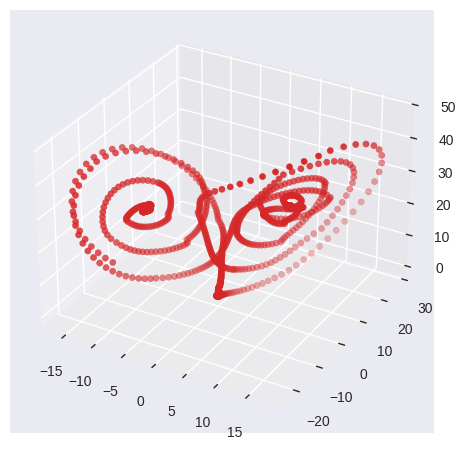

In [8]:
plt.style.use('seaborn-v0_8')
ax = plt.figure().add_subplot(projection='3d')
#ax.scatter(S_train[0,2000:4000], S_train[1,2000:4000], S_train[2,2000:4000], alpha=0.5, c='tab:blue', label='Training data')
ax.scatter(S_list[0].detach().numpy(), S_list[1].detach().numpy(), S_list[2].detach().numpy(), c='tab:red', label='Controlled Trajectory')
plt.show()

Plot the controlled and reference trajectories.

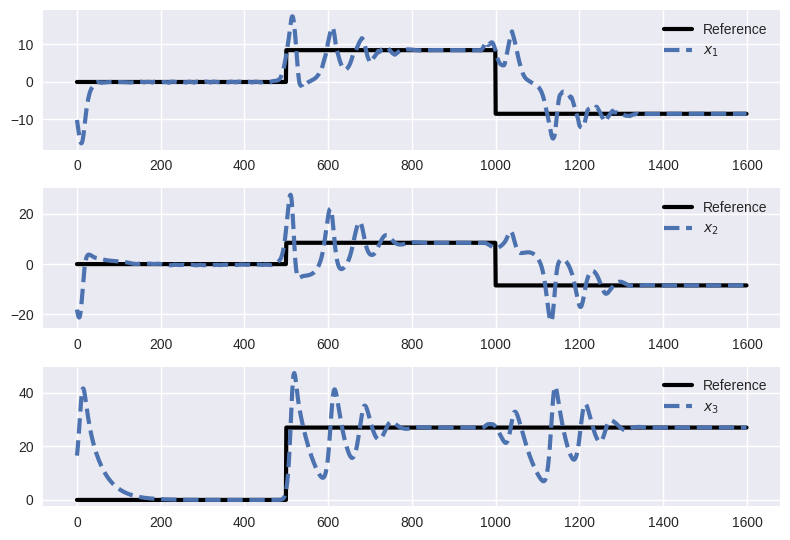

In [9]:
fig, ax = plt.subplots(3)


ax[0].plot(ref_traj[0][:1600], c='k', linewidth=3, label='Reference')
ax[0].plot(S_list[0], '--', linewidth=3, label='$x_1$')
ax[0].legend()


ax[1].plot(ref_traj[1][:1600], c='k', linewidth=3, label='Reference')
ax[1].plot(S_list[1], '--', linewidth=3, label='$x_2$')
ax[1].legend()

ax[2].plot(ref_traj[2][:1600], c='k', linewidth=3, label='Reference')
ax[2].plot(S_list[2], '--', linewidth=3, label='$x_3$')
ax[2].legend()

plt.tight_layout()
plt.show()

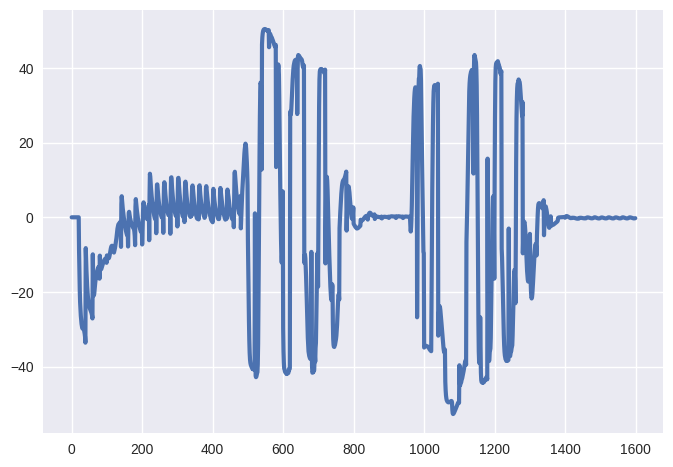

In [10]:
fig, ax = plt.subplots()
plt.plot(U_list[0], linewidth=3)

In [11]:
dev=100
u_1=5
u_2=20
cost = dev * torch.linalg.norm(S_list - ref_traj[:,:1600])
cost += u_1 * torch.linalg.norm(U_list)
cost += u_2 * torch.linalg.norm(torch.diff(U_list))
print('ESN Cost: ')
print(cost)

ESN Cost: 
tensor(52357.9775, dtype=torch.float64)
